In [1]:
import pdb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import pdb

%matplotlib inline

In [2]:
'''Data loading'''
f_names_national = [
    '2012 Conso Prod.csv',
    '2013 Conso Prod.csv',
    '2014 Conso Prod.csv',
    '2015 Conso Prod.csv'
]

datas = []
data_news = []
for f_name in f_names_national:
#     print(f_name)
    data = pd.read_csv('data/'+ f_name, delimiter='\t', encoding = "ISO-8859-1")
    pd.set_option('max_columns', 100)
    headers = list(data)
    data = data[data.Consommation.notnull()]
    data = data[data.Date.notnull()]
    data['timestamp'] = [str(d) + ' ' + str(t) for d, t in zip(data['Date'].values, data['Heures'].values)]
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M')
    datas.append(data)

data_final = pd.concat(datas).reset_index()


/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [241]:
# Sorting values : le premier élement du data set est le plus récent : 
# y(t), y(t-1) etc... 
data_final = data_final.sort_values(by=['Date','Heures'], ascending=[False,False])

'''tau : paramètre de périodicité'''
tau = 48 # 48 : on considère une corrélation de 24h. On pourrait prendre tau = 1 an 
            # afin de correler les données avec les données de l'année passée

def data_labels(dataframe=data_final, field='Consommation', tau = tau):
    X = dataframe[field].values
    X_ = np.stack([np.roll(X,i) for i in range(tau+1)], axis=1)

    labels = X_[:,:1]
    data = X_[:,1:]
    return data, labels


In [12]:
# Creating the training set and the crossvalidation set.
# two years of training, 1 year for cv 
n_samples = data_final.Consommation.values.shape[0]
data_train, labels_train = data_labels(dataframe = data_final[data_final['Date'] <= '2014-12-31'])
data_test, labels_test = data_labels(dataframe = data_final[data_final['Date'] > '2014-12-31'])

# ANN 

In [5]:
import pandas
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [6]:
# fix random seed for reproducibility
np.random.seed(7)

In [85]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(20, input_dim=tau, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(data_train, labels_train, nb_epoch=200, batch_size=100, verbose=2)

Epoch 1/200
1s - loss: 76732832.1334
Epoch 2/200
0s - loss: 12535201.9116
Epoch 3/200
0s - loss: 7589177.6366
Epoch 4/200
0s - loss: 6206680.0042
Epoch 5/200
0s - loss: 5267879.3379
Epoch 6/200
0s - loss: 4450848.4411
Epoch 7/200
0s - loss: 3809339.2652
Epoch 8/200
0s - loss: 3357957.1846
Epoch 9/200
0s - loss: 2995924.9217
Epoch 10/200
0s - loss: 2734035.8179
Epoch 11/200
0s - loss: 2492950.3347
Epoch 12/200
0s - loss: 2268454.0255
Epoch 13/200
0s - loss: 2050694.7677
Epoch 14/200
0s - loss: 1890919.7407
Epoch 15/200
0s - loss: 1757363.6692
Epoch 16/200
0s - loss: 1618920.8193
Epoch 17/200
0s - loss: 1474036.6266
Epoch 18/200
1s - loss: 1387352.0489
Epoch 19/200
0s - loss: 1318926.2669
Epoch 20/200
0s - loss: 1273723.9635
Epoch 21/200
0s - loss: 1196673.9354
Epoch 22/200
0s - loss: 1140463.7339
Epoch 23/200
0s - loss: 1085810.6211
Epoch 24/200
0s - loss: 1058718.7604
Epoch 25/200
0s - loss: 1067054.9161
Epoch 26/200
0s - loss: 1045034.9121
Epoch 27/200
0s - loss: 1000579.9129
Epoch 28

In [86]:
# Estimate model performance
trainScore = model.evaluate(data_train, labels_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(data_test, labels_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 469957.37 MSE (685.53 RMSE)
Test Score: 463903.28 MSE (681.10 RMSE)


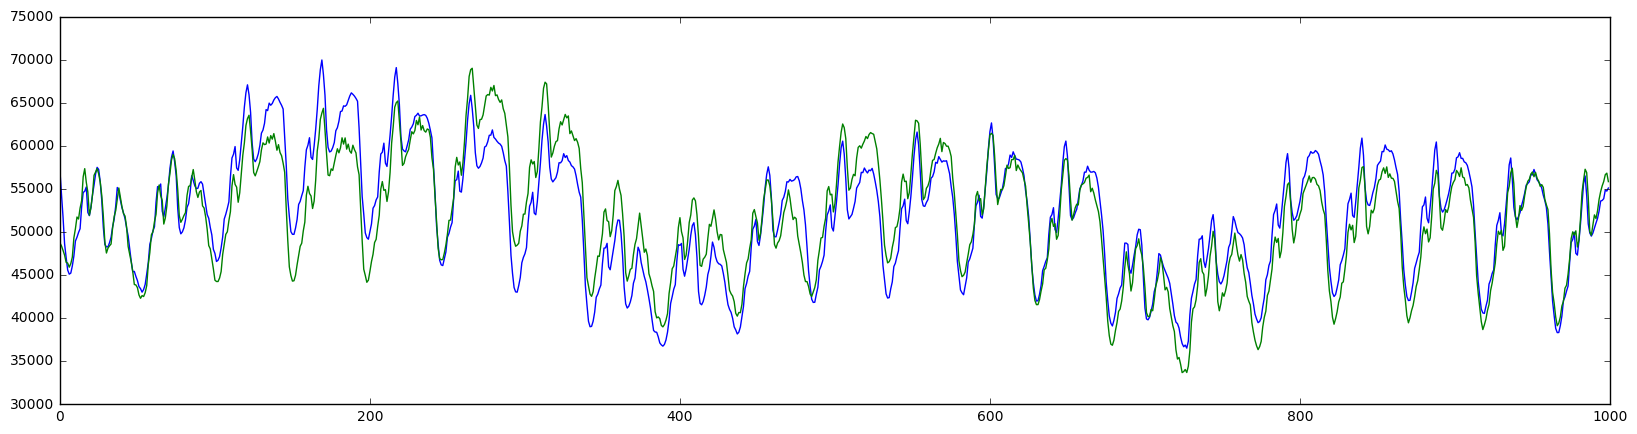

In [87]:
# generate predictions for training
trainPredict = model.predict(data_train)
testPredict = model.predict(data_test)

# shift train predictions for plotting
trainPredictPlot = np.zeros((n_samples,1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[tau:len(trainPredict), :] = trainPredict[:-tau,:]
# shift test predictions for plotting
testPredictPlot = np.zeros((n_samples,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(tau)+1:(n_samples), :] = testPredict[:-tau-1,:]
# plot baseline and predictions
sl= slice(20000,21000)
plt.figure(figsize=(20,5))
plt.plot(data_final['Consommation'].values[sl])
plt.plot(trainPredictPlot[sl])
plt.plot(testPredictPlot[sl])
plt.show()

# Genetic Algorithm

In [198]:
population_size = 2
num_generations = 1000
crossover_weights = 0.9
bestfit = 1e-4
max_hidden_layers = 4
max_nodes = 20
maxlags = 10
minF = 0.99

In [88]:
params = {'time_lags' : 48, 'hidden_units' : 20, 'training_algo' : "adam" }
params_minmax = {'time_lags' : [1, 100], 'hidden_units' : [1, 1000], 'training_algo' : "adam" }

In [237]:

class Individual(object):
    """An individual in a population."""

    def __init__(self, vector):
        """Initialize with an encoded vector and fitness function."""
        self.phenotype = self.validate_vector(vector)
        print(self.phenotype)
        self.fitness = self.calculate_fitness()

    def validate_vector(self, vector, params_minmax= params_minmax):
        """Make sure all elements are between minmax"""
        validated_vector = {}
        for key in vector:
            if (vector[key] <= params_minmax[key][1]) & (vector[key] >= params_minmax[key][0]):
                validated_vector[key] = vector[key]
            else :
                pass
                
        return validated_vector

    def calculate_fitness(self):
        """Get the individual's fitness. EXPENSIVE."""
        # run network 
        NN = NeuralNetwork(phenotype = self.phenotype)
        NN.fitness()
        
        return NN.fitness

In [280]:
# param du reseau : 
# nb de couches et neurones
class NeuralNetwork(object):
    
    def __init__(self, phenotype):
        self.phenotype = phenotype
        self.individual_trained = 0
        self.lags = phenotype['time_lags']
        
    # create and fit Multilayer Perceptron model
    
    def train(self, X, Y) :
#         np.random.seed(7) #  ? 
        self.model = Sequential()
        self.model.add(Dense(self.phenotype['hidden_units'], 
                        input_dim=self.phenotype['time_lags'], 
                        activation='relu'))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.model.fit(X, Y, nb_epoch=1, batch_size=100, verbose=1)
        self.individual_trained = 1        
    
    def fitness(self) :
        X_train, Y_train = data_labels(dataframe = data_final[data_final['Date'] <= '2014-12-31'], tau=self.lags)
        X_test, Y_test = data_labels(dataframe = data_final[data_final['Date'] > '2014-12-31'], tau=self.lags)
        
        if self.individual_trained == 0 :
            print ("Training MLP")
            self.train(X= X_train, Y= Y_train)
        self.trainPredict = self.model.predict(X_train)
        self.testPredict = self.model.predict(X_test)
        self.trainScore = self.model.evaluate(X_train, Y_train, verbose=0)
        self.testScore = self.model.evaluate(X_test, Y_test, verbose=0)
        self.fitness = 1 / (1 + self.testScore)
        print("Fitness = %.2e" %(self.fitness))

In [285]:
# Initialize the population at t=0 - build list of Individual objects
class Population(object):
    
    def __init__(self, params, params_minmax):
        self.params = params
        self.params_minmax = params_minmax
    
        self.initial_population = []

        for individual in range(0, population_size):

            individual_dico = {}
            individual_dico.clear()
#             pdb.set_trace()

            individual_dico['hidden_units'] = np.random.randint(
                self.params_minmax['hidden_units'][0], self.params_minmax['hidden_units'][1])
            individual_dico['time_lags'] = np.random.randint(
                self.params_minmax['time_lags'][0], self.params_minmax['time_lags'][1])
            print(individual_dico)
            new_individual = Individual(individual_dico)
            self.initial_population.append(new_individual)



In [286]:
Population = Population(params,params_minmax)

{'hidden_units': 4, 'time_lags': 73}
{'hidden_units': 4, 'time_lags': 73}
Training MLP
Epoch 1/1
52608/52608 [==============================] - 3s - loss: 54148726.1654     
Fitness = 7.01e-08
{'hidden_units': 491, 'time_lags': 82}
{'hidden_units': 491, 'time_lags': 82}
Training MLP
Epoch 1/1
52608/52608 [==============================] - 5s - loss: 67526751.1972     
Fitness = 1.86e-07


In [530]:
class Evolution(object):
    
    def __init__(self, population_initiale, params_minmax= params_minmax, w=crossover_weights):
        self.population = population_initiale
        self.popu_size = len(population_initiale)
        self.params_minmax = params_minmax
        self.w = w
        
    
    def select_parent(self):
        i, j = np.random.choice(np.arange(0,self.popu_size), 2, replace = False) 
        return (i, j)
    
    def crossover(self, i, j ):
        papa = self.population[i].phenotype
        self.nb_params = len(papa)
        maman = self.population[j].phenotype
        C = np.zeros((4, len(papa)))
        M = np.zeros(C.shape)
        for k, key in enumerate(papa):
            c1 = (papa[key] + maman[key])/2
            c2 = params_minmax[key][1] * (1-self.w) + max(papa[key], maman[key]) *self.w
            c3 = params_minmax[key][0] * (1-self.w) + min(papa[key], maman[key]) *self.w
            c4 = (params_minmax[key][1]- params_minmax[key][0]) * (1-self.w) +\
                (papa[key] + maman[key])/2
            
            C[0,k] = c1 
            C[1,k] = c2
            C[2,k] = c3
            C[3,k] = c4
            
            for l in range(4) :
                M[l,k] = np.random.randint(params_minmax[key][0]- C[l,k], \
                                    params_minmax[key][1]+ C[l,k])
            
        return C, M, convert_to_dict(C)

    
    def mutation(self, C, M):
        # 1st mutation 
        sig = np.zeros(len(papa))
        sig[np.random.choice(len(papa))]=1

        for l in range(4):
            self.Mutation1 = C[l,:] + np.multiply(M[l,:],sig)

        # 2nd mutation 
        sig = np.zeros(len(papa))
        sig[np.random.choice(len(papa),len(papa),replace=True)]=1

        for l in range(4):
            self.Mutation2 = C[l,:] + np.multiply(M[l,:],sig)

        # 3rd mutation 
        sig = np.one(len(papa))

        for l in range(4):
            self.Mutation3 = C[l,:] + np.multiply(M[l,:],sig)
            
        return convert_to_dict(self.Mutation1)

    def convert_to_dict(self, vector):
        n = vector.shape[0]
        key = ['hidden_units', 'time_lags']
        return [dict(zip(key, vector[l,:]))  for l in range(1)]
        
        
        


In [531]:
Evo = Evolution(Population.initial_population)

In [527]:
Evo.convert_to_dict(np.array([[2,3]]))

[{'hidden_units': 2, 'time_lags': 3}]